In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy

In [10]:
batch_size = 1
num_workers = 1

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

## Have to use this flag while running above
# CUBLAS_WORKSPACE_CONFIG=:16:8 or CUBLAS_WORKSPACE_CONFIG=:4096:2


In [13]:
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')
train_indices = torch.arange(20000)
test_indices = torch.arange(1000)
train_data = data_utils.Subset(train_data, train_indices)
test_data = data_utils.Subset(test_data, test_indices)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=256,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
print(f'train data size:{len(train_loader.dataset)}')
print(f'test data size:{len(test_loader.dataset)}')

class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x     

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 10, decrease_freq_after = None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                if batch>300:
                    terminate_training = True
                    break
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # print('Batch:', batch)
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessian(X,y))
                    
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            if sub_batch> batch: # only taking the encountered points to calculate train loss
                                break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 100 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
            

# net = Net(input_features=784, hidden_sizes = [16], output_size = 10)
# print(net)
# params = list(net.parameters())
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters())
train_nn = Train_nn(784, [16], 10,lr= 0.001)

train data size:20000
test data size:1000


In [14]:
from torch.nn.utils import _stateless

In [8]:
train_nn.fit(train_loader, test_loader, epochs=1, store_grads=True,store_hessian=False, store_freq=10, store_gen_err=True, store_pt_loss=True, store_weights=True)

  0%|          | 0/20000 [00:00<?, ?batch/s]

	accuracy:9.1
	loss: 2.209228
	accuracy:10.8
	loss: 2.361486
	accuracy:13.7
	loss: 2.172824
	accuracy:17.1
	loss: 2.320117


In [7]:
# plt.plot(train_nn.grads_norms)

In [8]:
# plt.plot(train_nn.grads_norms)

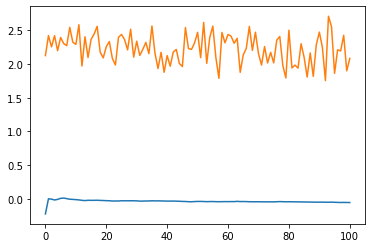

In [10]:
plt.plot(np.array(train_nn.train_loss) - np.array(train_nn.val_loss))
plt.plot(train_nn.point_loss)

In [215]:
X,y = iter(train_loader).next()
X, y = X.to(device), y.to(device)
def local_model(*params):
    # print(f'len of params:{len(params)}')
    # print(f'shape of params[0]:{params[0].shape}')
    with torch.no_grad():
        #initialize model with given params
        i = 0
        var = torch.tensor(1.).to(device)
        print(params[1].shape)
        for param in train_nn.model.parameters():
            param.data = torch.zeros(params[i].shape[0], params[i].shape[1])
            i += 1
        pred = train_nn.model(X)
        loss = train_nn.loss_fn(pred, y)
        # print(f'loss type:{type(loss)}')
    return loss

In [216]:
hess_mat = hessian(local_model, tuple(list(train_nn.model.parameters())))

torch.Size([])


IndexError: tuple index out of range

In [ ]:
hess_mat[0][0][0][0]

In [63]:
with torch.no_grad():
    params = copy.deepcopy(train_nn.model.parameters())
    print(list(train_nn.model.parameters())[0][0][0])
    list(train_nn.model.parameters())[0][0][0]=2
    print(list(train_nn.model.parameters())[0][0][0])
    print(params[0][0][0])

TypeError: cannot pickle 'generator' object

In [47]:
params[0][0][0]=1

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [43]:
train_nn.model.state_dict()['fc1.weight'][0][0]

tensor(2., device='cuda:0')

In [21]:
new_val = torch.tensor(2.).to(device)
for param in train_nn.model.parameters():
    param.data[0][0] = new_val
    break


In [22]:
params_changed = list(train_nn.model.parameters())

In [23]:
params_changed[0][0][0]

tensor(2., device='cuda:0', grad_fn=<SelectBackward0>)

In [24]:
params[0][0][0]

tensor(2., device='cuda:0', grad_fn=<SelectBackward0>)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0549, 0.0039, 0.6039, 0.9922, 0.3529, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

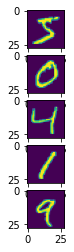

In [43]:
fig, ax = plt.subplots(5)
for i, (data, label) in enumerate(train_loader):
    if i>= 5:
        break
    ax[i].imshow(data.reshape(28,28))

iter(train_loader).next()[0].reshape(28,28)[10]

In [115]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [113]:
model_ip = torch.ones(5,784)
out = net(model_ip)
print('out', out.shape)
criterion = nn.CrossEntropyLoss()

target = torch.ones(5, dtype = torch.long)
print(target)
loss = criterion(out, target)

out torch.Size([5, 10])
tensor([1, 1, 1, 1, 1])


tensor(2.3769, grad_fn=<NllLossBackward0>)

In [73]:
net.zero_grad()
out.backward(torch.randn(2,10))

In [48]:
for param in net.parameters():
    # print(param)
    print(param.grad.data)

AttributeError: 'NoneType' object has no attribute 'data'

In [54]:
def func(x):
    return x[0]**2 + 4*x[1]**3 -10*x[2]

In [55]:
def func2d(x):
    return x[0][0]**2 + 4*x[0][1]**3 -10*x[1][0]

In [56]:
ip2d = torch.tensor([[1.,1.],[2.,1.]]) 
print(ip2d)
ip1d = torch.flatten(ip2d)
print(ip1d)

print('1d')
print(hessian(func, ip1d))
print('2d')
hess_2d = hessian(func2d, ip2d)
print(hess_2d)
print(torch.reshape(hess_2d, (4,4)))

tensor([[1., 1.],
        [2., 1.]])
tensor([1., 1., 2., 1.])
1d
tensor([[ 2.,  0.,  0.,  0.],
        [ 0., 24.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])
2d
tensor([[[[ 2.,  0.],
          [ 0.,  0.]],

         [[ 0., 24.],
          [ 0.,  0.]]],


        [[[ 0.,  0.],
          [ 0.,  0.]],

         [[ 0.,  0.],
          [ 0.,  0.]]]])
tensor([[ 2.,  0.,  0.,  0.],
        [ 0., 24.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])


In [98]:
def func_const(*x):
    return torch.tensor(5.)

In [104]:
p =list(train_nn.model.parameters())
print(type(tuple(p)))
p_hes = hessian(func_const, tuple(p))
print(len(p_hes))

<class 'tuple'>
4


In [105]:
print(p_hes[0][0].shape)

torch.Size([16, 784, 16, 784])


In [162]:
base_h_dim = list(p_hes[0][0].shape)
base_h_dim = [4*4] + base_h_dim
p_hes_t = np.zeros(base_h_dim)
p_hes_t = torch.tensor(p_hes_t)
print(f'p_hes_t shape:{p_hes_t.shape}')

p_hes_t shape:torch.Size([16, 16, 784, 16, 784])


In [163]:
p_hes_list = [0]*4*4
for i in range(4):
    for j in range(4):
        p_hes_list[i*4 + j] = torch.unsqueeze(p_hes[i][j],0)

In [164]:
p_hes_list[0].shape

torch.Size([1, 16, 784, 16, 784])

In [169]:
torch.cat(tuple(p_hes_list), out=p_hes_t.to(device))

RuntimeError: Tensors must have same number of dimensions: got 5 and 4

In [156]:
p_hes[0][0].shape

torch.Size([16, 784, 16, 784])

In [62]:
ip1d = torch.flatten(ip2d)
print(ip1d)

print('1d')
print(hessian(func, ip1d))
print(hessian(func_const, ip1d))

tensor([1., 1., 2., 1.])
1d
tensor([[ 2.,  0.,  0.,  0.],
        [ 0., 24.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [46]:
class Testnet(nn.Module):

    def __init__(self, input_features, hidden_sizes, output_size):
        super(Testnet, self).__init__()
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_sizes[0])
        self.total_params_len += input_features*hidden_sizes[0] + hidden_sizes[0]
        self.fc2 = nn.Linear(hidden_sizes[0], output_size)
        self.total_params_len += hidden_sizes[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        # x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
test_net = Testnet(2,[1],1)

In [47]:
list(test_net.parameters())

[Parameter containing:
 tensor([[ 0.1769, -0.0553]], requires_grad=True),
 Parameter containing:
 tensor([-0.2762], requires_grad=True),
 Parameter containing:
 tensor([[0.6002]], requires_grad=True),
 Parameter containing:
 tensor([0.2901], requires_grad=True)]